In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

['workspace/811c3b5e401ba0adcedd67a67dbf2457\\analysis_data\\hp_data.npy', 'workspace/811c3b5e401ba0adcedd67a67dbf2457\\analysis_data\\hp_names.npy']


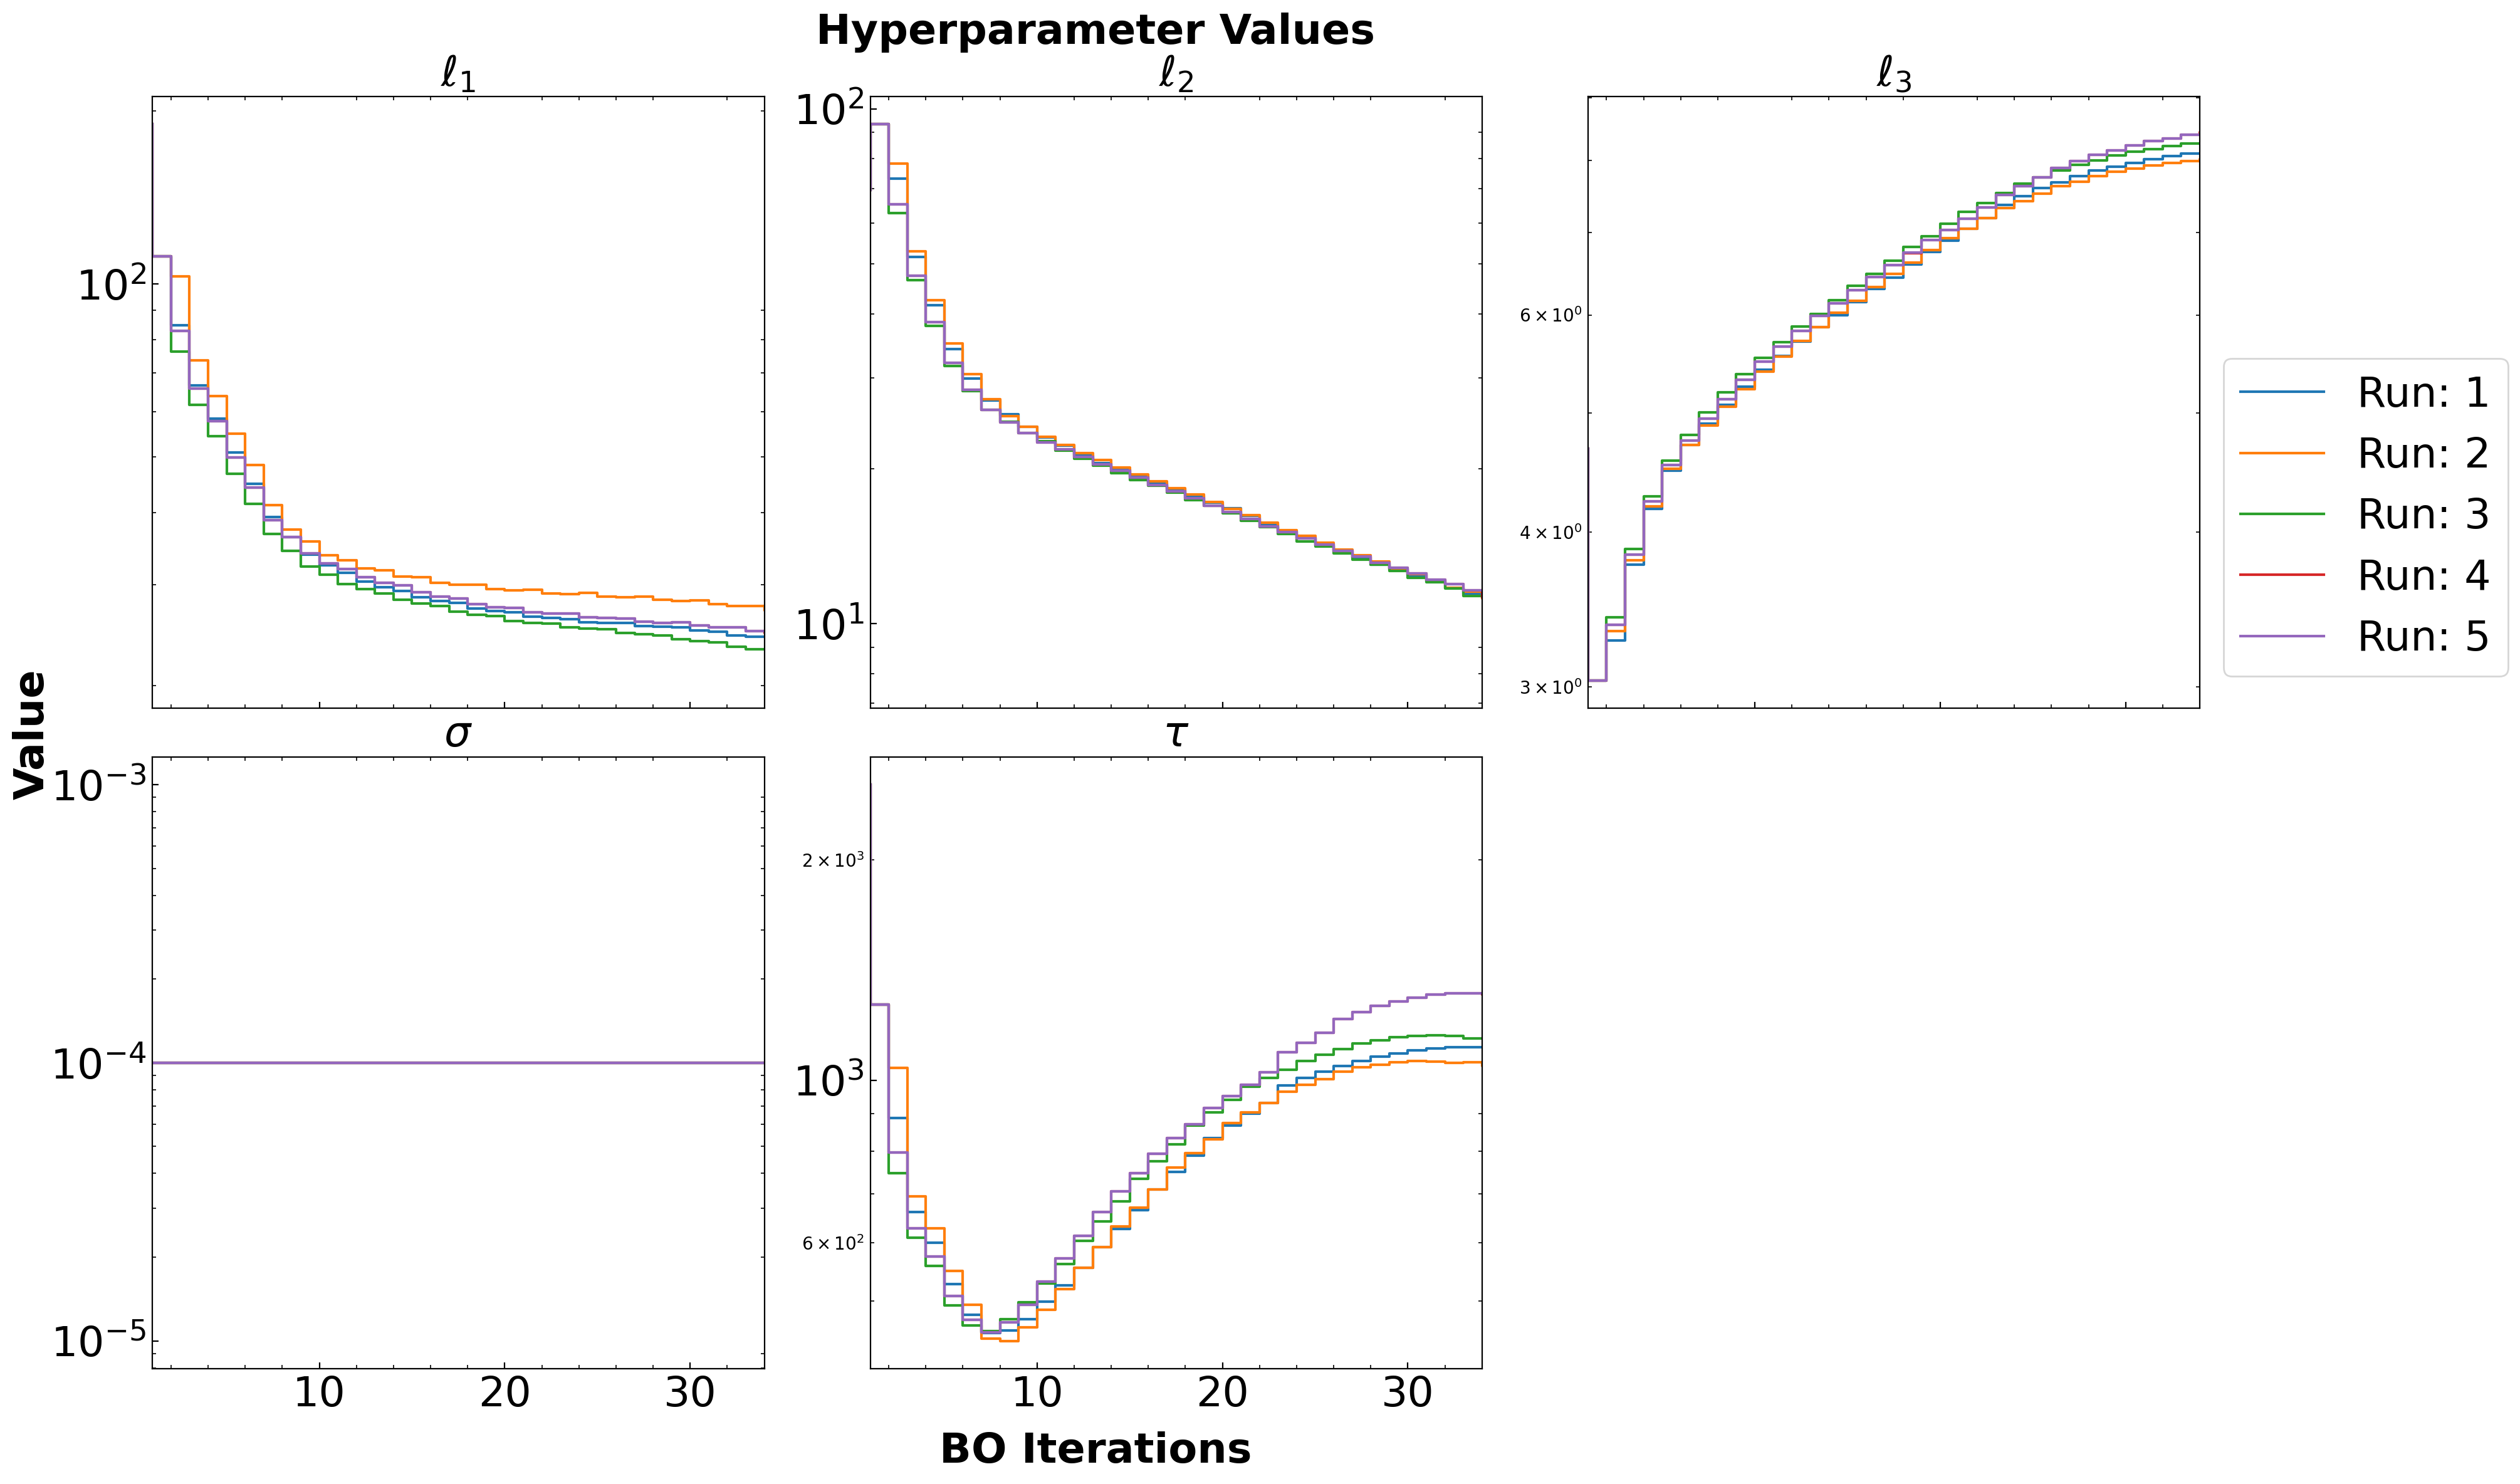

In [2]:
#Get HP Plots
#Set parameters
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

x_label = "BO Iterations"
y_label = "Value"
title = "Hyperparameter Values"
plot_dict = make_plot_dict(False, title, x_label, y_label, ybins = 7, line_levels = None, save_path=None)

hps, hp_names, hp_true = analyze_hypers(file_path, save_csv = True)
plot_2D_Data_w_BO_Iter(hps, hp_names, hp_true, plot_dict)

In [ ]:
#From signac
import signac
meth_name_val_list = [1, 2, 3, 4, 5, 6]
save_csv = False

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": {"$gte": 1},
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": 1,
                 "meth_name_val": {"$in": meth_name_val_list}}

# criteria_dict = {"cs_name_val" : 1,
#                  "param_name_str" : "t1t2",
#                  "ep_enum_val":1,
#                  "retrain_GP": 25,
#                  "num_x_data": 5,
#                  "outputscl": None,
#                  "bo_iter_tot": 50,
#                  "lenscl": None}

df, job_list, theta_true = get_df_all_jobs(criteria_dict, save_csv)
# print(df.head())

In [ ]:
### Get Best Data from ep experiment
df_best, job_list_best = get_best_data(criteria_dict, df, job_list, theta_true, save_csv)

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)
    
df_best

In [ ]:
run_num_list = list(map(int, df_best["Run Number"].to_numpy()))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy()))
bo_method_list = list(df_best["BO Method"].to_numpy())

In [ ]:
z_choices = ["ei", "min_sse", "sse"]

x_label = "BO Iterations"
y_label = r"$\mathbf{e(\theta)}$"
# y_label = "Max " + r"$\mathbf{EI(\theta)}$"

plot_dict = make_plot_dict(False, None, x_label, None, line_levels = None, save_path=None)

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_objs_all_methods(file_path_list, run_num_list, z_choices, plot_dict)

#This image goes in study results folder

In [ ]:
#Make Heat maps for all pairs
z_choices = ["sse_sim", "sse_mean", "sse_var", "ei"]
levels = [100,100,100,100]

#Loop over best jobs
for i in range(len(job_list_best)):   
    #Set file path
    file_path = job_list_best[i].fn("BO_Results.gz")
    #Back out number of parameters
    string_val = df_best["Theta Min Obj"].iloc[0]
    try:
        numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    except:
        numbers = [float(num) for num in string_val]
    #Create list of parameter pair combinations
    dim_theta = len(np.array(numbers).reshape(-1, 1))
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    
    #Loop over parameter pairs
    for pair in range(pairs):
        plot_dict = make_plot_dict(False, None, None, None, line_levels = levels, save_path=None)
       
        #Set save path
#         save_path = job_list[i].fn("Results/" + make_dir_name_from_criteria(criteria_dict) + "/")

        plot_hms_gp_compare(file_path, run_num_list[i], bo_iter_list[i], pair, z_choices, plot_dict)

In [ ]:
pair = 0
z_choice = "sse_mean"
# title = "Heat Map Pair " + z_choice
levels = [100,100,100, 100, 100, 100]
plot_dict = make_plot_dict(False, None, None, None, line_levels = levels, save_path=None)
file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_hms_all_methods(file_path_list, run_num_list, bo_iter_list, pair, z_choice, plot_dict)

In [ ]:
#Get sse, log_sse, and ei plots
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz" #CS1 2D Best

z_choices = ["sse", "min_sse", "ei"]

x_label = "BO Iterations"
y_label = "Values"
title = None
plot_dict = make_plot_dict(False, title, x_label, y_label, ybins = 7, line_levels = None, save_path=None)

data, data_names, data_true, GP_meth_val = analyze_sse_min_sse_ei(file_path, z_choices)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, plot_dict)

In [ ]:
z_choice = "ei"

x_label = "BO Iterations"
# y_label = r"$\mathbf{e(\theta)}$"
y_label = "Max " + r"$\mathbf{EI(\theta)}$"
# title = "Min SSE Values"
plot_dict = make_plot_dict(False, None, x_label, y_label, line_levels = None, save_path=None)

file_path_list = [job.fn("BO_Results.gz") for job in job_list]

plot_one_obj_all_methods(file_path_list, run_num_list, z_choice, plot_dict)

In [ ]:
#Get theta @ min sse
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

z_choice = "sse"

x_label = "BO Iterations"
title = "Min Obj Parameter Values"

plot_dict = make_plot_dict(False, title, x_label, None, line_levels = None, save_path=None)

data, data_names, data_true = analyze_thetas(file_path, z_choice)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, plot_dict)

In [ ]:
#Get theta @ min sse overall
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

z_choice = "min_sse"

x_label = "BO Iterations"
title = "Min Obj Parameter Values Overall"

plot_dict = make_plot_dict(False, title, x_label, None, line_levels = None, save_path=None)

data, data_names, data_true = analyze_thetas(file_path, z_choice)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, plot_dict)

In [ ]:
#Get theta @ Max EI
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

z_choice = "ei"

x_label = "BO Iterations"
y_label = "Theta Values"
title = "Max EI Parameter Values"

plot_dict = make_plot_dict(False, title, x_label, y_label, line_levels = None, save_path=None)

data, data_names, data_true = analyze_thetas(file_path, z_choice)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, plot_dict)

In [ ]:
# #Get Median Data from sf experiment
df_median, job_list_med = get_median_data(criteria_dict, df, job_list, theta_true, save_csv)

for i in range(len(job_list_med)): 
    print(job_list_med[i].id)
    
df_median

In [ ]:
# #Get Mean Data from sf experiment
df_mean, job_list_mean = get_mean_data(criteria_dict, df, job_list, theta_true, save_csv)

for i in range(len(job_list_mean)): 
    print(job_list_mean[i].id)
    
df_mean